In [2]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf

In [3]:
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
pop = pd.read_csv('Data/census_estimate.csv')
# Rename columns and take weekly incidence instead of daily
cases21['date'] = pd.to_datetime(cases21['date'])
cases21 = cases21[cases21['date'] >= '2021-04-01']
cases21.set_index('date', inplace=True)
cases20['date'] = pd.to_datetime(cases20['date'])
cases20.set_index('date', inplace=True)
weekly_counts_21 = cases21.groupby(['area_code','area_name']).resample('W')['value'].sum().reset_index()
weekly_counts_20 = cases20.groupby(['area_code','area_name']).resample('W')['value'].sum().reset_index()
# Convert incidence to a proportion to allow for cross-LTLA comparison
weekly_counts_21 = pd.merge(weekly_counts_21,pop,on='area_code')
weekly_counts_21['incidence'] = weekly_counts_21['value'] / weekly_counts_21['population']
weekly_counts_20 = pd.merge(weekly_counts_20,pop,on='area_code')
weekly_counts_20['incidence'] = weekly_counts_20['value'] / weekly_counts_20['population']
# .head() for sanity check
weekly_counts_21.head()

,area_code,area_name,date,value,population,incidence
0,E06000001,Hartlepool,2021-04-04,19.0,93836,0.000202
1,E06000001,Hartlepool,2021-04-11,38.0,93836,0.000405
2,E06000001,Hartlepool,2021-04-18,30.0,93836,0.000320
3,E06000001,Hartlepool,2021-04-25,16.0,93836,0.000171
4,E06000001,Hartlepool,2021-05-02,10.0,93836,0.000107


In [4]:
# Add in the NHS regions for spatial detrending
npis = pd.read_csv('Data/npis_23Mar_02Dec.csv')
npis = npis[['ltla20nm','region']]
npis.drop_duplicates(inplace=True)

manual_dat = pd.DataFrame({'ltla20nm': ['Wycombe','South Bucks','Chiltern','Aylesbury Vale'], \
                           'region': ['South East', 'South East', 'South East', 'South East']})
npis = pd.concat([npis,manual_dat])
npis.head()

,ltla20nm,region
0,Adur,South East
255,Allerdale,North West
510,Amber Valley,East Midlands
765,Arun,South East
1020,Ashfield,East Midlands


In [5]:
# Add in the NHS regions for spatial detrending
weekly_counts_21 = pd.merge(weekly_counts_21, npis, left_on='area_name', right_on='ltla20nm')
weekly_counts_21.drop(columns='ltla20nm',inplace=True)
weekly_counts_20 = pd.merge(weekly_counts_20, npis, left_on='area_name', right_on='ltla20nm')
weekly_counts_20.drop(columns='ltla20nm',inplace=True)
weekly_counts_21.head()

,area_code,area_name,date,value,population,incidence,region
0,E06000001,Hartlepool,2021-04-04,19.0,93836,0.000202,North East
1,E06000001,Hartlepool,2021-04-11,38.0,93836,0.000405,North East
2,E06000001,Hartlepool,2021-04-18,30.0,93836,0.000320,North East
3,E06000001,Hartlepool,2021-04-25,16.0,93836,0.000171,North East
4,E06000001,Hartlepool,2021-05-02,10.0,93836,0.000107,North East


In [6]:
# Get the regional mean inicidences and spatially detrend 2021
regional_mean = weekly_counts_21.groupby(['region', 'date'])['incidence'].mean().reset_index()
regional_mean.rename(columns={'incidence': 'regional_mean_incidence'}, inplace=True)
weekly_counts_21 = pd.merge(weekly_counts_21, regional_mean, on=['region', 'date'])
weekly_counts_21['detrended'] = weekly_counts_21['incidence'] - weekly_counts_21['regional_mean_incidence']
weekly_counts_21.head()

,area_code,area_name,date,value,population,incidence,region,regional_mean_incidence,detrended
0,E06000001,Hartlepool,2021-04-04,19.0,93836,0.000202,North East,0.000142,0.000060
1,E06000001,Hartlepool,2021-04-11,38.0,93836,0.000405,North East,0.000237,0.000168
2,E06000001,Hartlepool,2021-04-18,30.0,93836,0.000320,North East,0.000151,0.000168
3,E06000001,Hartlepool,2021-04-25,16.0,93836,0.000171,North East,0.000127,0.000044
4,E06000001,Hartlepool,2021-05-02,10.0,93836,0.000107,North East,0.000119,-0.000012


In [7]:
# Get the regional mean inicidences and spatially detrend 2020
regional_mean20 = weekly_counts_20.groupby(['region', 'date'])['incidence'].mean().reset_index()
regional_mean20.rename(columns={'incidence': 'regional_mean_incidence'}, inplace=True)
weekly_counts_20 = pd.merge(weekly_counts_20, regional_mean20, on=['region', 'date'])
weekly_counts_20['detrended'] = weekly_counts_20['incidence'] - weekly_counts_20['regional_mean_incidence']
weekly_counts_20.head()

,area_code,area_name,date,value,population,incidence,region,regional_mean_incidence,detrended
0,E06000001,Hartlepool,2020-06-07,24.0,93836,0.000256,North East,0.000136,0.000120
1,E06000001,Hartlepool,2020-06-14,15.0,93836,0.000160,North East,0.000097,0.000063
2,E06000001,Hartlepool,2020-06-21,3.0,93836,0.000032,North East,0.000047,-0.000015
3,E06000001,Hartlepool,2020-06-28,6.0,93836,0.000064,North East,0.000039,0.000025
4,E06000001,Hartlepool,2020-07-05,2.0,93836,0.000021,North East,0.000020,0.000001


In [8]:
# Convert to wide format for ease of future calculations
wide_data = weekly_counts_21.pivot(index='date', columns='area_name', values='detrended')
wide_data20 = weekly_counts_20.pivot(index='date', columns='area_name', values='detrended')
wide_data.head()

area_name,Adur,Allerdale,Amber Valley,Arun,Ashfield,Ashford,Aylesbury Vale,Babergh,Barking and Dagenham,Barnet,...,Woking,Wokingham,Wolverhampton,Worcester,Worthing,Wychavon,Wycombe,Wyre,Wyre Forest,York
date,,,,,,,,,,,,,,,,,,,,,
2021-04-04,-0.000039,-0.000079,-0.000104,-0.000009,-0.000026,0.000006,-0.000017,-0.000050,0.000042,0.000017,...,0.000109,-0.000019,0.000134,0.000014,-0.000016,-0.000063,0.000010,-0.000069,0.000032,-0.000190
2021-04-11,-0.000043,-0.000128,-0.000225,0.000081,-0.000116,-0.000098,0.000086,-0.000109,0.000095,0.000065,...,0.000074,0.000054,0.000058,-0.000051,-0.000055,-0.000104,0.000175,-0.000133,-0.000052,-0.000319
2021-04-18,-0.000013,-0.000106,-0.000145,0.000011,-0.000090,-0.000038,0.000072,-0.000045,0.000029,0.000042,...,0.000073,0.000008,0.000057,0.000036,-0.000062,-0.000075,0.000135,-0.000087,-0.000084,-0.000186
2021-04-25,-0.000004,-0.000124,-0.000111,0.000008,-0.000018,-0.000021,0.000057,-0.000095,-0.000060,-0.000021,...,0.000012,0.000058,0.000050,-0.000034,-0.000088,-0.000086,0.000081,-0.000109,0.000064,-0.000168
2021-05-02,-0.000016,-0.000144,-0.000098,0.000008,-0.000051,-0.000056,0.000042,-0.000060,-0.000044,-0.000042,...,-0.000009,-0.000021,0.000011,-0.000007,-0.000006,-0.000091,0.000031,-0.000051,-0.000087,-0.000151


In [9]:
# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    return ews_data

In [10]:
# Get signals
ews_521 = calculate_ews_rolling(wide_data,window_size=5)
ews_1021 = calculate_ews_rolling(wide_data, window_size=10)
ews_1020 = calculate_ews_rolling(wide_data20,window_size=10)
ews_520 = calculate_ews_rolling(wide_data20,window_size=5)

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),figsize=(8,12))
for i, stat in enumerate(ews_520.keys()):
    stat_data = ews_520[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_1020[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i],logy=True,color='red',label='Window = 10')
        axs[i].legend()
    else:
        y_data.plot(ax=axs[i],color='blue')
        x_data.plot(ax=axs[i],color='red')
    axs[i].set_ylabel(stat)
fig.suptitle('Maidstone, 2020')
fig.tight_layout()
plt.show()

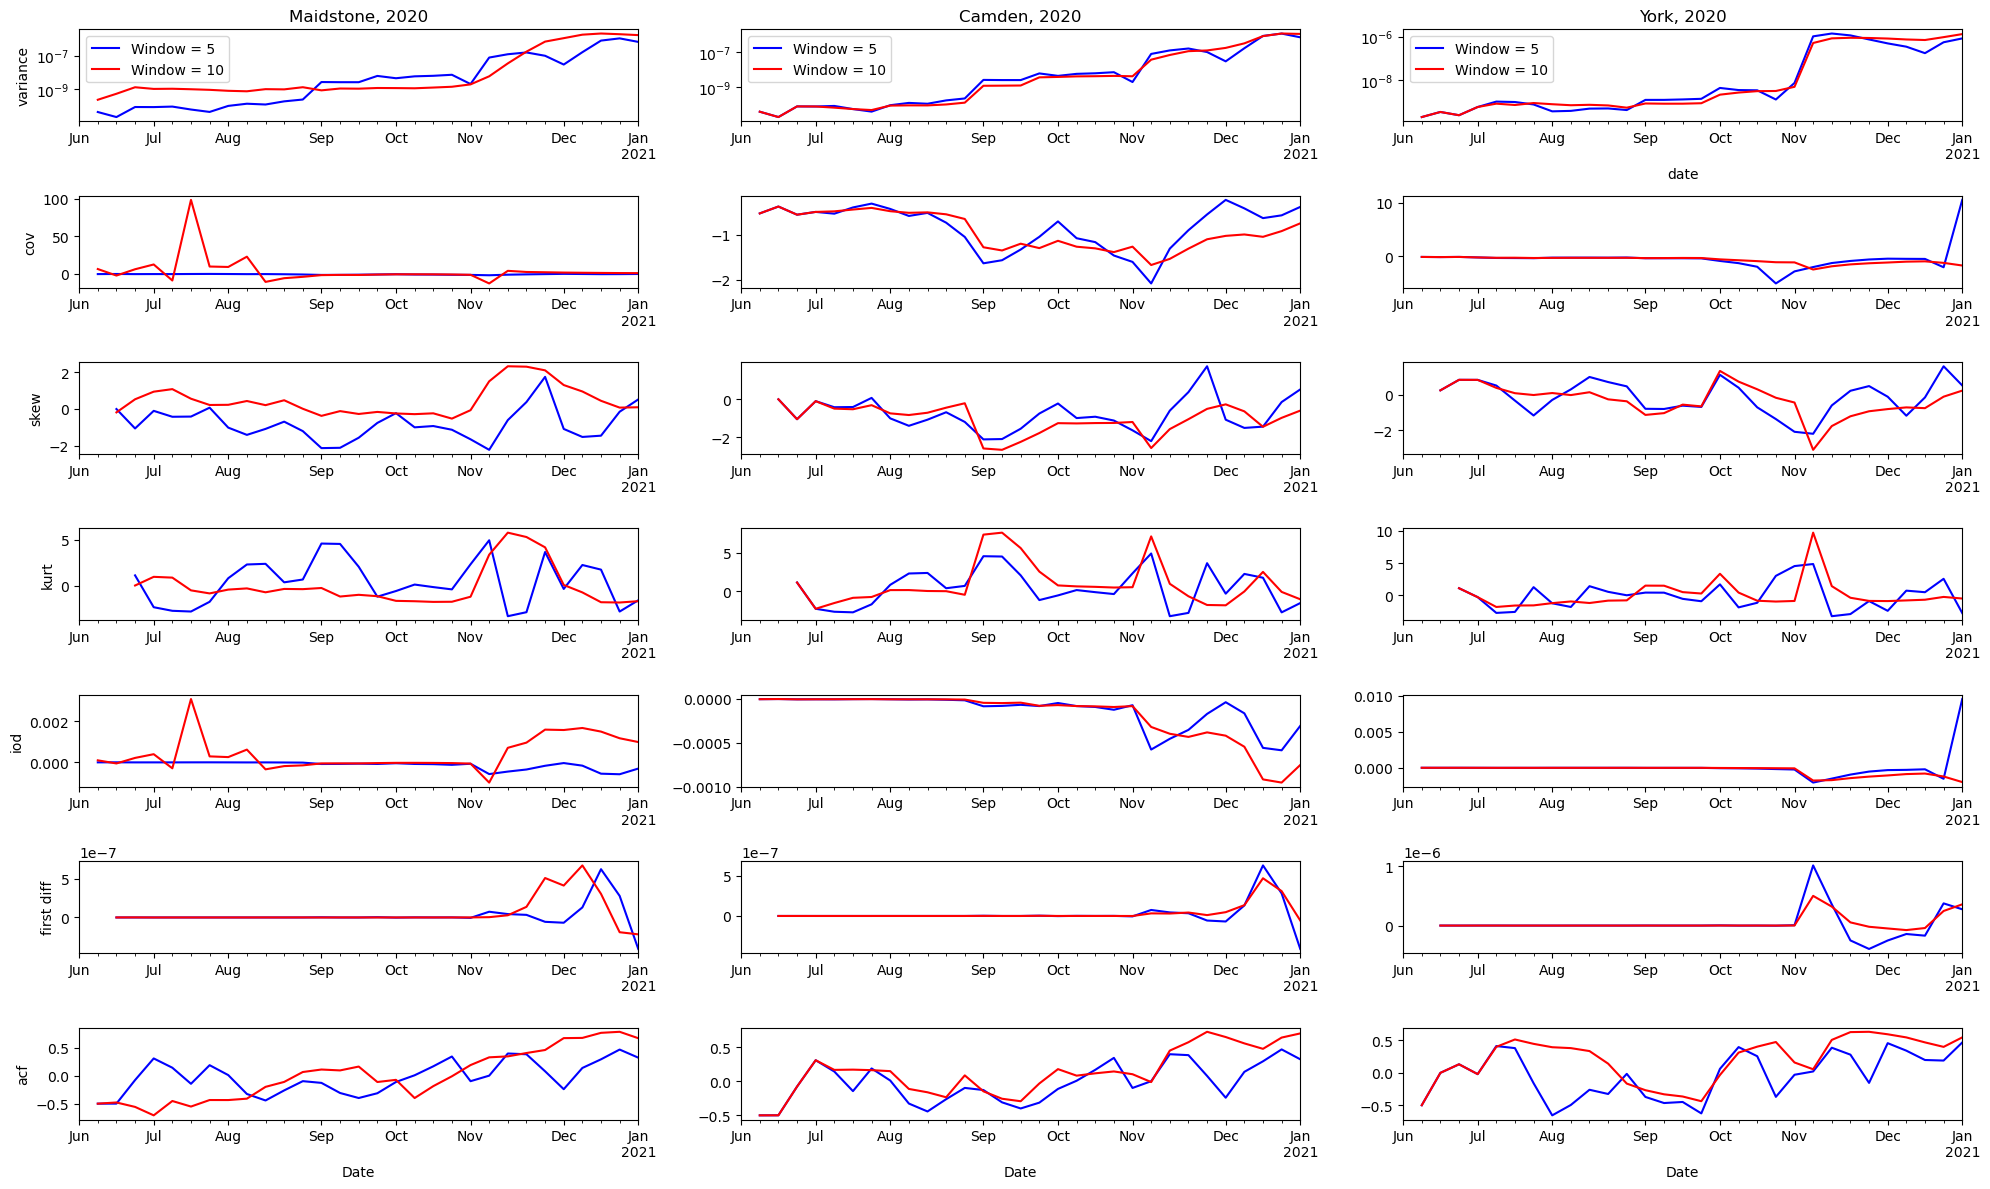

In [94]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_520.keys()):
    stat_data = ews_520[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1020[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 10')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2020')
    else:
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_520.keys()):
    stat_data = ews_520[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1020[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 10')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2020')
    else:
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_520.keys()):
    stat_data = ews_520[stat]
    y_data = stat_data['York']
    stat_data = ews_1020[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 10')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2020')
    else:
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
        axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

fig.tight_layout()
plt.show()

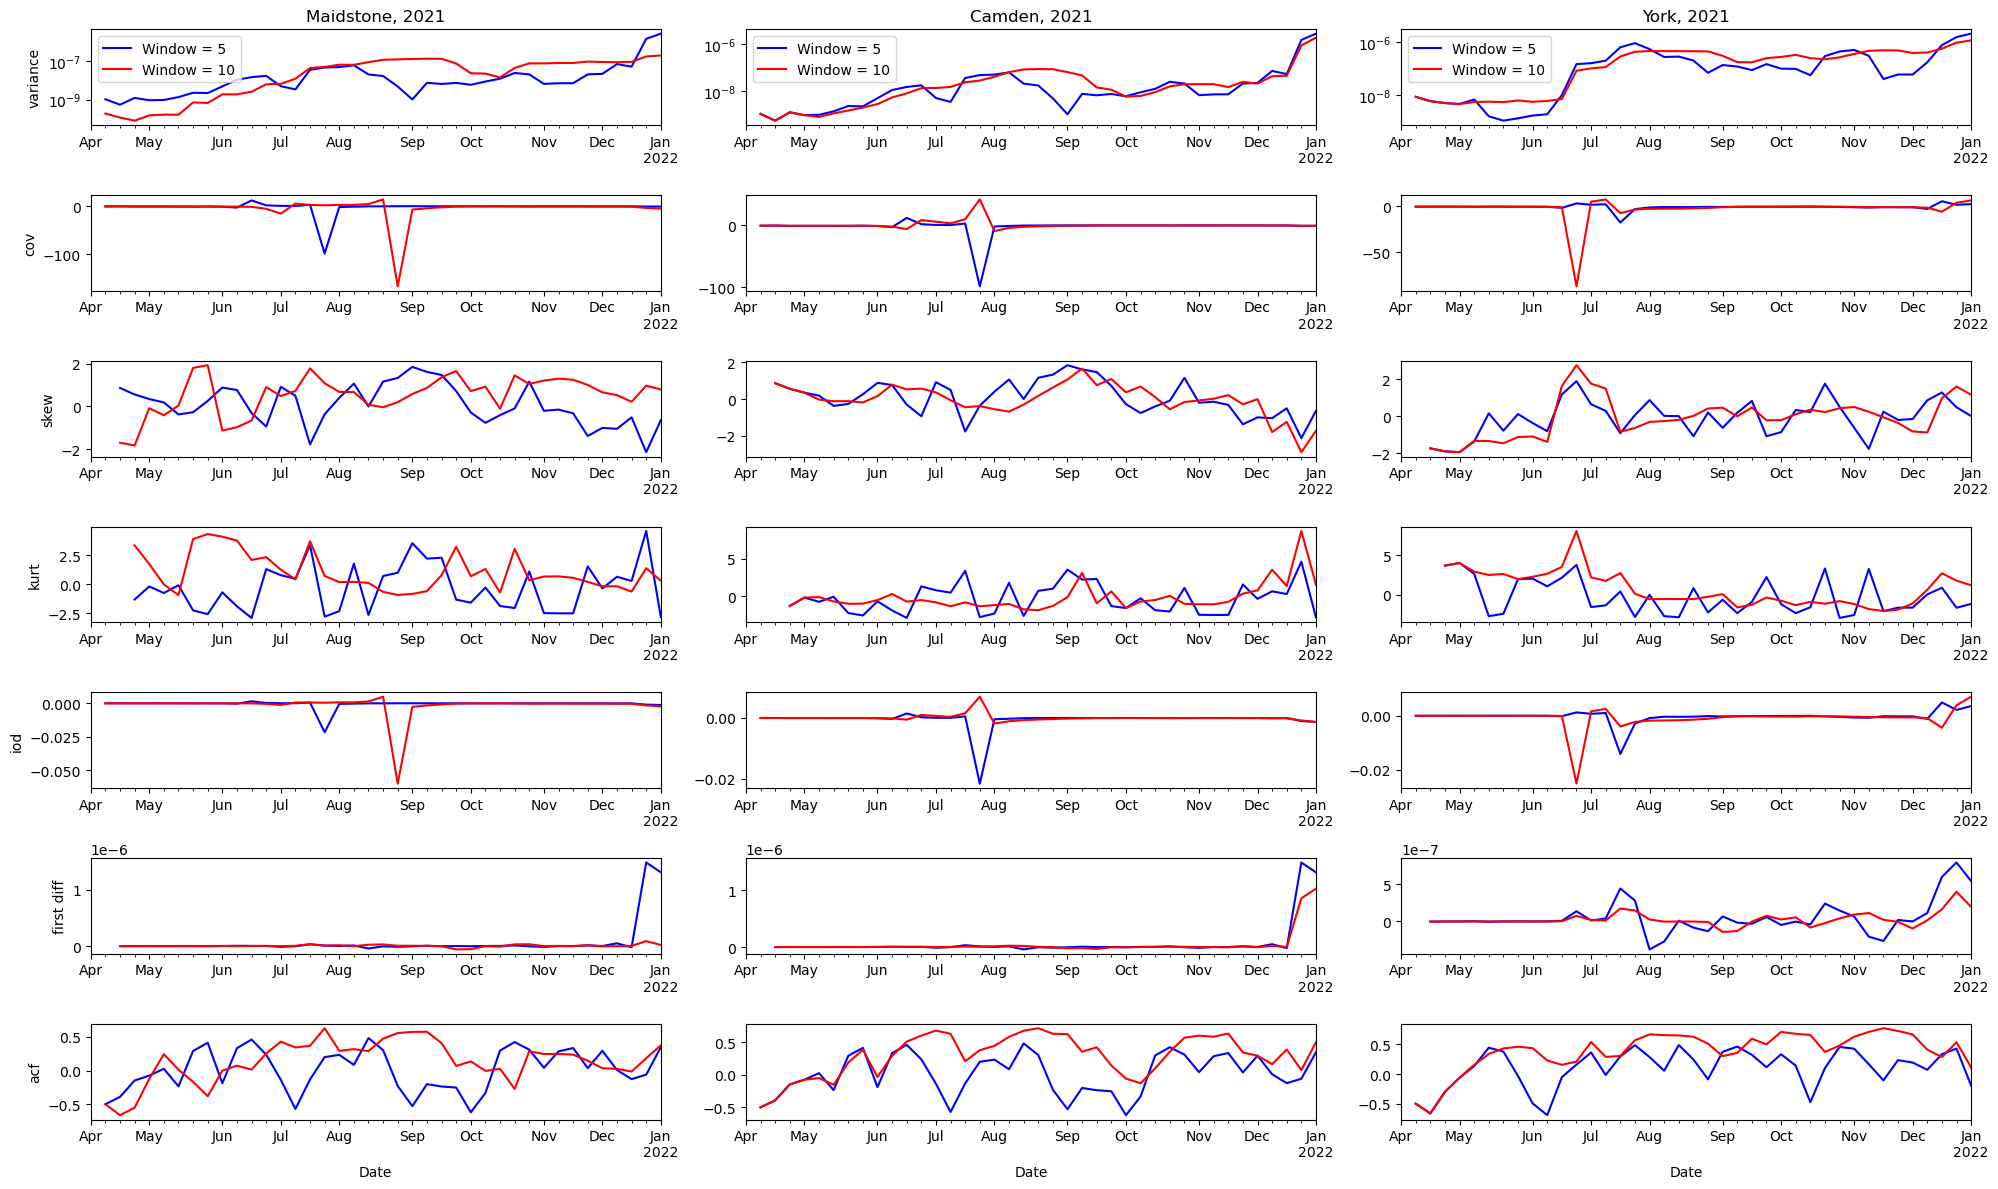

In [93]:
fig, axs = plt.subplots(nrows=len(ews_521.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_521.keys()):
    stat_data = ews_521[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1021[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 10')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2021')
    else:
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_521.keys()):
    stat_data = ews_521[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1021[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 10')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2021')
    else:
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_521.keys()):
    stat_data = ews_521[stat]
    y_data = stat_data['York']
    stat_data = ews_1021[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 10')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2021')
    else:
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
    axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),figsize=(8,12))
for i, stat in enumerate(ews_520.keys()):
    stat_data = ews_520[stat]
    y_data = stat_data['York']
    stat_data = ews_1020[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i],logy=True,color='red',label='Window = 10')
        axs[i].legend()
    else:
        y_data.plot(ax=axs[i],color='blue')
        x_data.plot(ax=axs[i],color='red')
    axs[i].set_ylabel(stat)
fig.suptitle('York, 2020')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),figsize=(8,12))
for i, stat in enumerate(ews_520.keys()):
    stat_data = ews_520[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1020[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i],logy=True,color='red',label='Window = 10')
        axs[i].legend()
    else:
        y_data.plot(ax=axs[i],color='blue')
        x_data.plot(ax=axs[i],color='red')
    axs[i].set_ylabel(stat)
fig.suptitle('Camden, 2020')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_521.keys()),figsize=(8,12))
for i, stat in enumerate(ews_521.keys()):
    stat_data = ews_521[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_1021[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i],logy=True,color='red',label='Window = 10')
        axs[i].legend()
    else:
        y_data.plot(ax=axs[i],color='blue')
        x_data.plot(ax=axs[i],color='red')
    axs[i].set_ylabel(stat)
fig.suptitle('Maidstone, 2021')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_521.keys()),figsize=(8,12))
for i, stat in enumerate(ews_521.keys()):
    stat_data = ews_521[stat]
    y_data = stat_data['York']
    stat_data = ews_1021[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i],logy=True,color='red',label='Window = 10')
        axs[i].legend()
    else:
        y_data.plot(ax=axs[i],color='blue')
        x_data.plot(ax=axs[i],color='red')
    axs[i].set_ylabel(stat)
fig.suptitle('York, 2021')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_521.keys()),figsize=(8,12))
for i, stat in enumerate(ews_521.keys()):
    stat_data = ews_521[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1021[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i],logy=True,color='red',label='Window = 10')
        axs[i].legend()
    else:
        y_data.plot(ax=axs[i],color='blue')
        x_data.plot(ax=axs[i],color='red')
    axs[i].set_ylabel(stat)
fig.suptitle('Camden, 2021')
fig.tight_layout()
plt.show()

In [44]:
# Function to calculate K-tau over moving window
def kendall_tau_ews_moving(df, start, end, ltla):
    kendall_tau_stat = {}
    start = np.datetime64(start)
    end = np.datetime64(end)
    for stat in df.keys():
        ktau = {}
        ltla_data = df[stat]
        ltla_data = ltla_data[ltla].reset_index()
        ktau[ltla] = ltla_data.loc[(ltla_data['date']>=start) & (ltla_data['date']<=end)].corr(method = 'kendall').loc['date',ltla]
        
        kendall_tau_stat[stat] = pd.DataFrame(ktau, index = [0])
    return kendall_tau_stat

In [74]:
days = ews_1020['variance'].reset_index()['date'].values
ktau_520_camden = {}
ktau_1020_camden = {}
for end_date in days:
    five = kendall_tau_ews_moving(df = ews_520, start = days[0], end = end_date, ltla='Camden')
    ten = kendall_tau_ews_moving(df = ews_1020, start = days[0], end = end_date, ltla='Camden')
    ktau_520_camden[end_date] = pd.concat(five)['Camden']
    ktau_1020_camden[end_date] = pd.concat(ten)['Camden']
ktau_520_camden_df = pd.concat(ktau_520_camden).reset_index().groupby(['level_1','level_0']).mean()
ktau_520_camden_df.index.names = ['stat',r'Time t, $EWS \in$ [2020-06-07,t]']
ktau_1020_camden_df = pd.concat(ktau_1020_camden).reset_index().groupby(['level_1','level_0']).mean()
ktau_1020_camden_df.index.names = ['stat',r'Time t, $EWS \in$ [2020-06-07,t]']
ktau_520_camden_df.head()

level_2  Camden
stat Time t, $EWS \in$ [2020-06-07,t]                 
acf  2020-06-07                            0.0     NaN
     2020-06-14                            0.0     NaN
     2020-06-21                            0.0     1.0
     2020-06-28                            0.0     1.0
     2020-07-05                            0.0     1.0

In [ ]:
days = ews_1020['variance'].reset_index()['date'].values
ktau_520_Maidstone = {}
ktau_1020_Maidstone = {}
for end_date in days:
    five = kendall_tau_ews_moving(df = ews_520, start = days[0], end = end_date, ltla='Maidstone')
    ten = kendall_tau_ews_moving(df = ews_1020, start = days[0], end = end_date, ltla='Maidstone')
    ktau_520_Maidstone[end_date] = pd.concat(five)['Maidstone']
    ktau_1020_Maidstone[end_date] = pd.concat(ten)['Maidstone']
ktau_520_Maidstone_df = pd.concat(ktau_520_Maidstone).reset_index().groupby(['level_1','level_0']).mean()
ktau_520_Maidstone_df.index.names = ['stat',r'Time t, $EWS \in$ [2020-06-07,t]']
ktau_1020_Maidstone_df = pd.concat(ktau_1020_Maidstone).reset_index().groupby(['level_1','level_0']).mean()
ktau_1020_Maidstone_df.index.names = ['stat',r'Time t, $EWS \in$ [2020-06-07,t]']

In [79]:
days = ews_1020['variance'].reset_index()['date'].values
ktau_520_York = {}
ktau_1020_York = {}
for end_date in days:
    five = kendall_tau_ews_moving(df = ews_520, start = days[0], end = end_date, ltla='York')
    ten = kendall_tau_ews_moving(df = ews_1020, start = days[0], end = end_date, ltla='York')
    ktau_520_York[end_date] = pd.concat(five)['York']
    ktau_1020_York[end_date] = pd.concat(ten)['York']
ktau_520_York_df = pd.concat(ktau_520_York).reset_index().groupby(['level_1','level_0']).mean()
ktau_520_York_df.index.names = ['stat',r'Time t, $EWS \in$ [2020-06-07,t]']
ktau_1020_York_df = pd.concat(ktau_1020_York).reset_index().groupby(['level_1','level_0']).mean()
ktau_1020_York_df.index.names = ['stat',r'Time t, $EWS \in$ [2020-06-07,t]']

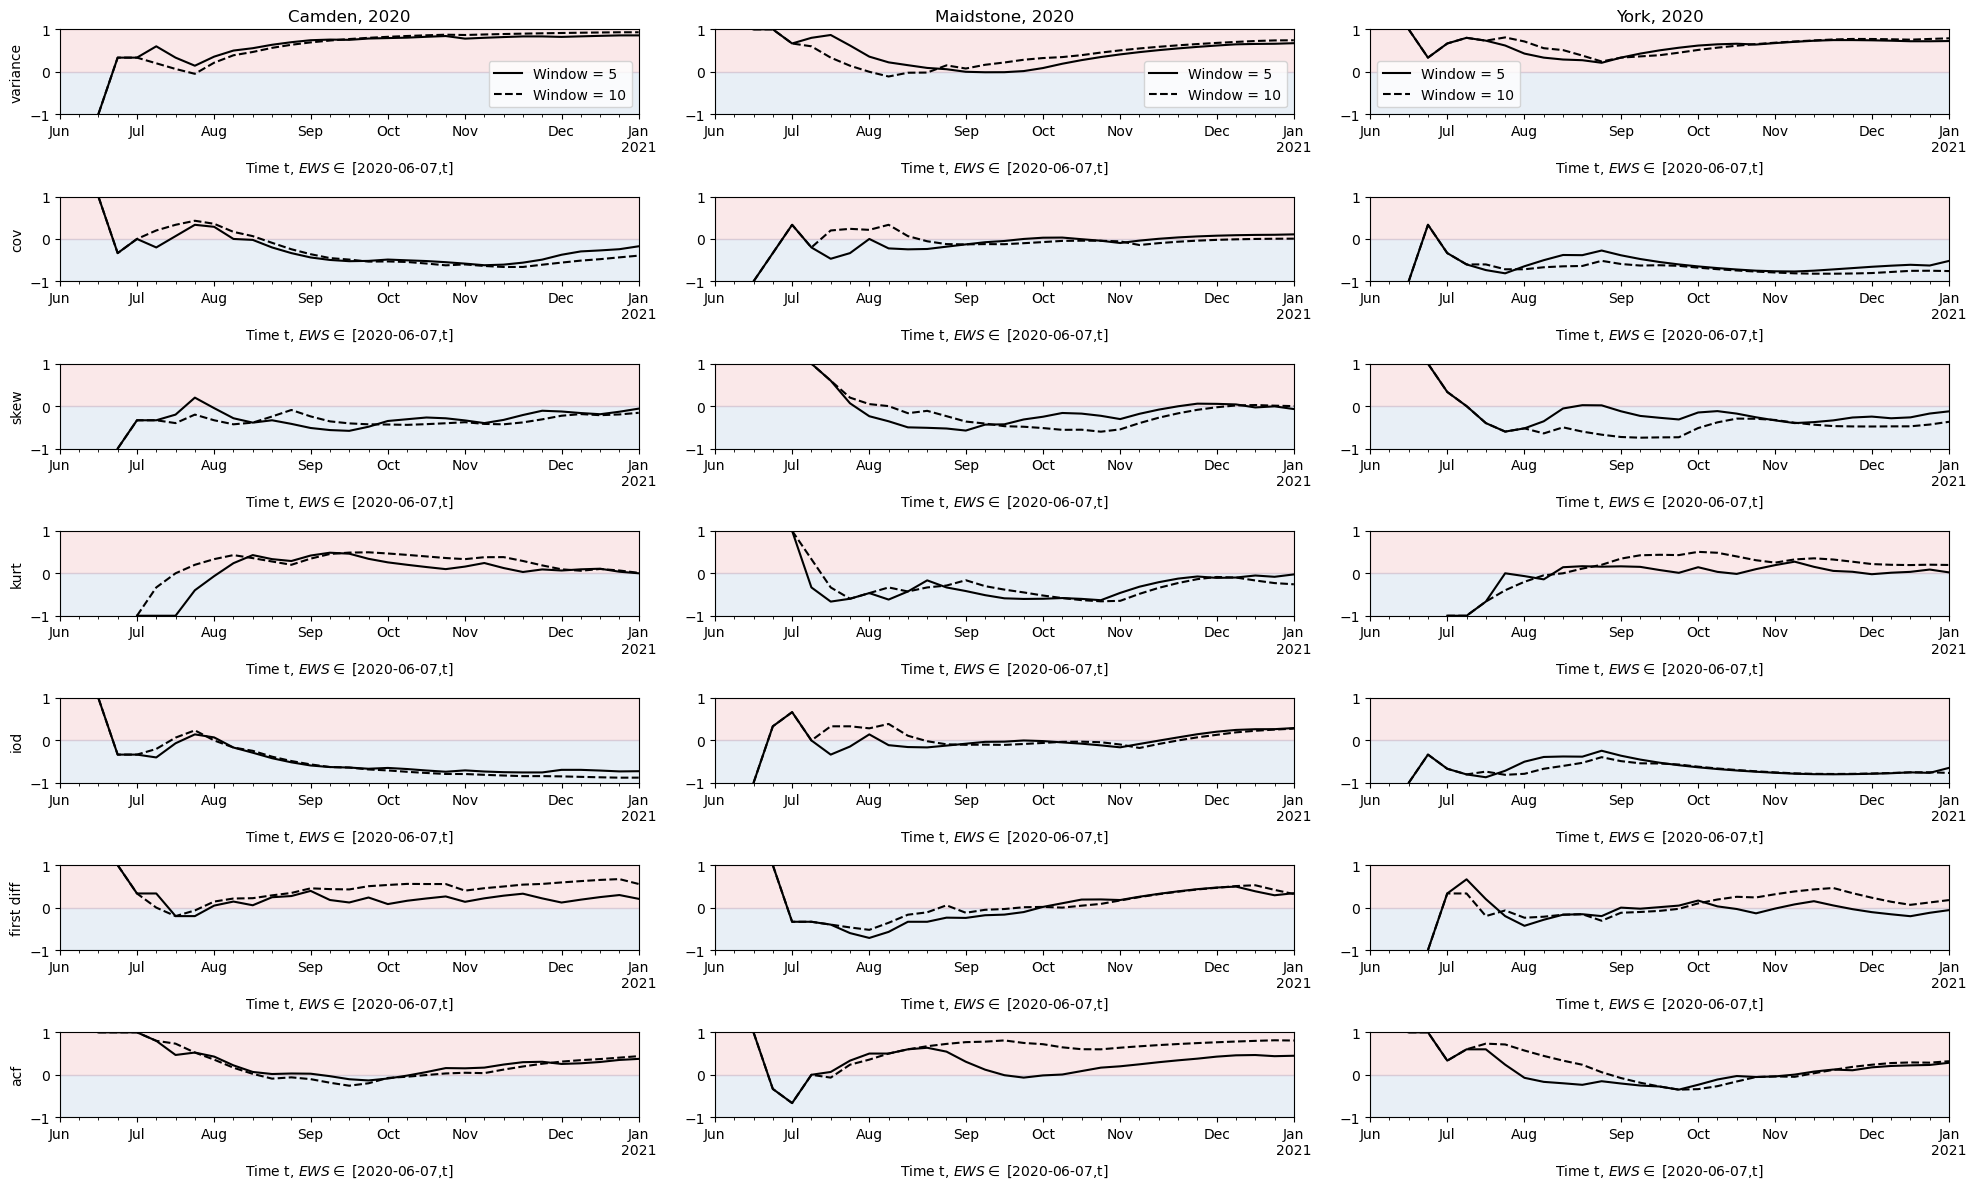

In [85]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_520.keys()):
    axs[i,0].set_ylim([-1,1])
    if (stat == "variance"):
        ktau_520_camden_df.xs(stat, level = 0).plot(ax=axs[i,0],y='Camden',
                                                    linestyle='-',color='k',label='Window = 5')
        ktau_1020_camden_df.xs(stat, level = 0).plot(ax=axs[i,0],y='Camden',
                                                     linestyle='--',color='k',label='Window = 10')
        axs[i,0].legend()
        axs[i,0].set_title('Camden, 2020')
    else:
        ktau_520_camden_df.xs(stat, level = 0).plot(ax=axs[i,0],y='Camden',
                                                    linestyle='-',color='k')
        ktau_1020_camden_df.xs(stat, level = 0).plot(ax=axs[i,0],y='Camden',
                                                     linestyle='--',color='k')
        axs[i,0].get_legend().set_visible(False)
    axs[i,0].fill_between(days, 1, 0, color='tab:red', alpha = 0.1)
    axs[i,0].fill_between(days, 0, -1, color='#2166ac', alpha = 0.1)
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)

for i, stat in enumerate(ews_520.keys()):
    axs[i,1].set_ylim([-1,1])
    if (stat == "variance"):
        ktau_520_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i,1],y='Maidstone',
                                                    linestyle='-',color='k',label='Window = 5')
        ktau_1020_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i,1],y='Maidstone',
                                                     linestyle='--',color='k',label='Window = 10')
        axs[i,1].legend()
        axs[i,1].set_title('Maidstone, 2020')
    else:
        ktau_520_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i,1],y='Maidstone',
                                                    linestyle='-',color='k')
        ktau_1020_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i,1],y='Maidstone',
                                                     linestyle='--',color='k')
        axs[i,1].get_legend().set_visible(False)
    axs[i,1].fill_between(days, 1, 0, color='tab:red', alpha = 0.1)
    axs[i,1].fill_between(days, 0, -1, color='#2166ac', alpha = 0.1)
    axs[i,1].xaxis.label.set_visible(False)

for i, stat in enumerate(ews_520.keys()):
    axs[i,2].set_ylim([-1,1])
    if (stat == "variance"):
        ktau_520_York_df.xs(stat, level = 0).plot(ax=axs[i,2],y='York',
                                                    linestyle='-',color='k',label='Window = 5')
        ktau_1020_York_df.xs(stat, level = 0).plot(ax=axs[i,2],y='York',
                                                     linestyle='--',color='k',label='Window = 10')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2020')
    else:
        ktau_520_York_df.xs(stat, level = 0).plot(ax=axs[i,2],y='York',
                                                    linestyle='-',color='k')
        ktau_1020_York_df.xs(stat, level = 0).plot(ax=axs[i,2],y='York',
                                                     linestyle='--',color='k')
        axs[i,2].get_legend().set_visible(False)
    axs[i,2].fill_between(days, 1, 0, color='tab:red', alpha = 0.1)
    axs[i,2].fill_between(days, 0, -1, color='#2166ac', alpha = 0.1)
    axs[i,2].xaxis.label.set_visible(False)
    
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),figsize=(8,12))
for i, stat in enumerate(ews_520.keys()):
    axs[i].set_ylim([-1,1])
    if (stat == "variance"):
        ktau_520_camden_df.xs(stat, level = 0).plot(ax=axs[i],y='Camden',
                                                    linestyle='-',color='k',label='Window = 5')
        ktau_1020_camden_df.xs(stat, level = 0).plot(ax=axs[i],y='Camden',
                                                     linestyle='--',color='k',label='Window = 10')
        axs[i].legend()
    else:
        ktau_520_camden_df.xs(stat, level = 0).plot(ax=axs[i],y='Camden',
                                                    linestyle='-',color='k')
        ktau_1020_camden_df.xs(stat, level = 0).plot(ax=axs[i],y='Camden',
                                                     linestyle='--',color='k')
        axs[i].get_legend().set_visible(False)
    axs[i].fill_between(days, 1, 0, color='tab:red', alpha = 0.1)
    axs[i].fill_between(days, 0, -1, color='#2166ac', alpha = 0.1)
    axs[i].set_ylabel(stat)
fig.suptitle('Camden, 2020')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),figsize=(8,12))
for i, stat in enumerate(ews_520.keys()):
    axs[i].set_ylim([-1,1])
    if (stat == "variance"):
        ktau_520_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i],y='Maidstone',
                                                    linestyle='-',color='k',label='Window = 5')
        ktau_1020_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i],y='Maidstone',
                                                     linestyle='--',color='k',label='Window = 10')
        axs[i].legend()
    else:
        ktau_520_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i],y='Maidstone',
                                                    linestyle='-',color='k')
        ktau_1020_Maidstone_df.xs(stat, level = 0).plot(ax=axs[i],y='Maidstone',
                                                     linestyle='--',color='k')
        axs[i].get_legend().set_visible(False)
    axs[i].fill_between(days, 1, 0, color='tab:red', alpha = 0.1)
    axs[i].fill_between(days, 0, -1, color='#2166ac', alpha = 0.1)
    axs[i].set_ylabel(stat)
fig.suptitle('Maidstone, 2020')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=len(ews_520.keys()),figsize=(8,12))
for i, stat in enumerate(ews_520.keys()):
    axs[i].set_ylim([-1,1])
    if (stat == "variance"):
        ktau_520_York_df.xs(stat, level = 0).plot(ax=axs[i],y='York',
                                                    linestyle='-',color='k',label='Window = 5')
        ktau_1020_York_df.xs(stat, level = 0).plot(ax=axs[i],y='York',
                                                     linestyle='--',color='k',label='Window = 10')
        axs[i].legend()
    else:
        ktau_520_York_df.xs(stat, level = 0).plot(ax=axs[i],y='York',
                                                    linestyle='-',color='k')
        ktau_1020_York_df.xs(stat, level = 0).plot(ax=axs[i],y='York',
                                                     linestyle='--',color='k')
        axs[i].get_legend().set_visible(False)
    axs[i].fill_between(days, 1, 0, color='tab:red', alpha = 0.1)
    axs[i].fill_between(days, 0, -1, color='#2166ac', alpha = 0.1)
    axs[i].set_ylabel(stat)
fig.suptitle('York, 2020')
fig.tight_layout()
plt.show()